## Libraries

In [1]:
try:
    import google.colab
    from google.colab import drive
    drive.mount('/content/drive', force_remount = True)
    IN_COLAB = True
except:
    IN_COLAB = False

In [2]:
if IN_COLAB:
    !pip install causalnex

In [3]:
if IN_COLAB:
    root_path = '/content/drive/MyDrive/Knowledge/MSIT/CSE575 - Statistical Machine Learning/Final Project'
else:
    root_path = '/Users/kscaria/Library/CloudStorage/GoogleDrive-scariakevin1@gmail.com/My Drive/Knowledge/MSIT/CSE575 - Statistical Machine Learning/Final Project'

import os
os.chdir(root_path)

In [4]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from causalnex.network import BayesianNetwork
from causalnex.structure.notears import from_pandas
from causalnex.plots import plot_structure
from causalnex.discretiser import Discretiser
from causalnex.evaluation import classification_report, roc_auc

## Causal Inference

### NOTEARS - Algorithm Introduction

More often than not, the domain knowledge required to create the structure for causal inference using Bayesian Netowrks in not known. Thus we make use the optimized [NOTEARS](https://arxiv.org/abs/1803.01422) algorithm (DAGs with NO TEARS: Continuous Optimization for Structure Learning) to extract all the hidden structures in the dataset.

### Preparing the Dataset

We now preprocess the dataset so that the NOTEARS algorithm can be used.

In [5]:
data = pd.read_csv('./data.csv')
data.shape

(569, 33)

In [6]:
data.head()

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean   
0    842302         M        17.99         10.38          122.80     1001.0  \
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean   
0          0.11840           0.27760          0.3001              0.14710  \
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  texture_worst  perimeter_worst  area_worst  smoothness_worst   
0  ...          17.33           184.60      2019.0            0.1622  \
1  ...          23.41           158.80      1956.0            0.1238   
2  ...          25.53           152.50      1709.0            0.1444   
3  ...          26.50            98.87       567.7            0.2098   
4  ...          16.67           152.20      1575.0            0.1374   

   compactness_worst  concavity_worst  concave points_worst  symmetry_worst   
0             0.6656           0.7119                0.2654          0.4601  \
1             0.1866           0.2416                0.1860          0.2750   
2             0.4245           0.4504                0.2430          0.3613   
3             0.8663           0.6869                0.2575          0.6638   
4             0.2050           0.4000                0.1625          0.2364   

   fractal_dimension_worst  Unnamed: 32  
0                  0.11890          NaN  
1                  0.08902          NaN  
2                  0.08758          NaN  
3                  0.17300          NaN  
4                  0.07678          NaN  

[5 rows x 33 columns]

*   We initially assume all features are important. There are 26 different features.
* NOTEARS algorithm expects no NULLs. Thus we remove all NULLs.
*   NOTEARS algorithm expects all data to be in numerical form. Thus we LabelEncode the features.



### Selecting the top features

In [7]:
# Drop ID column
data = data.drop(['id', 'Unnamed: 32'], axis=1)

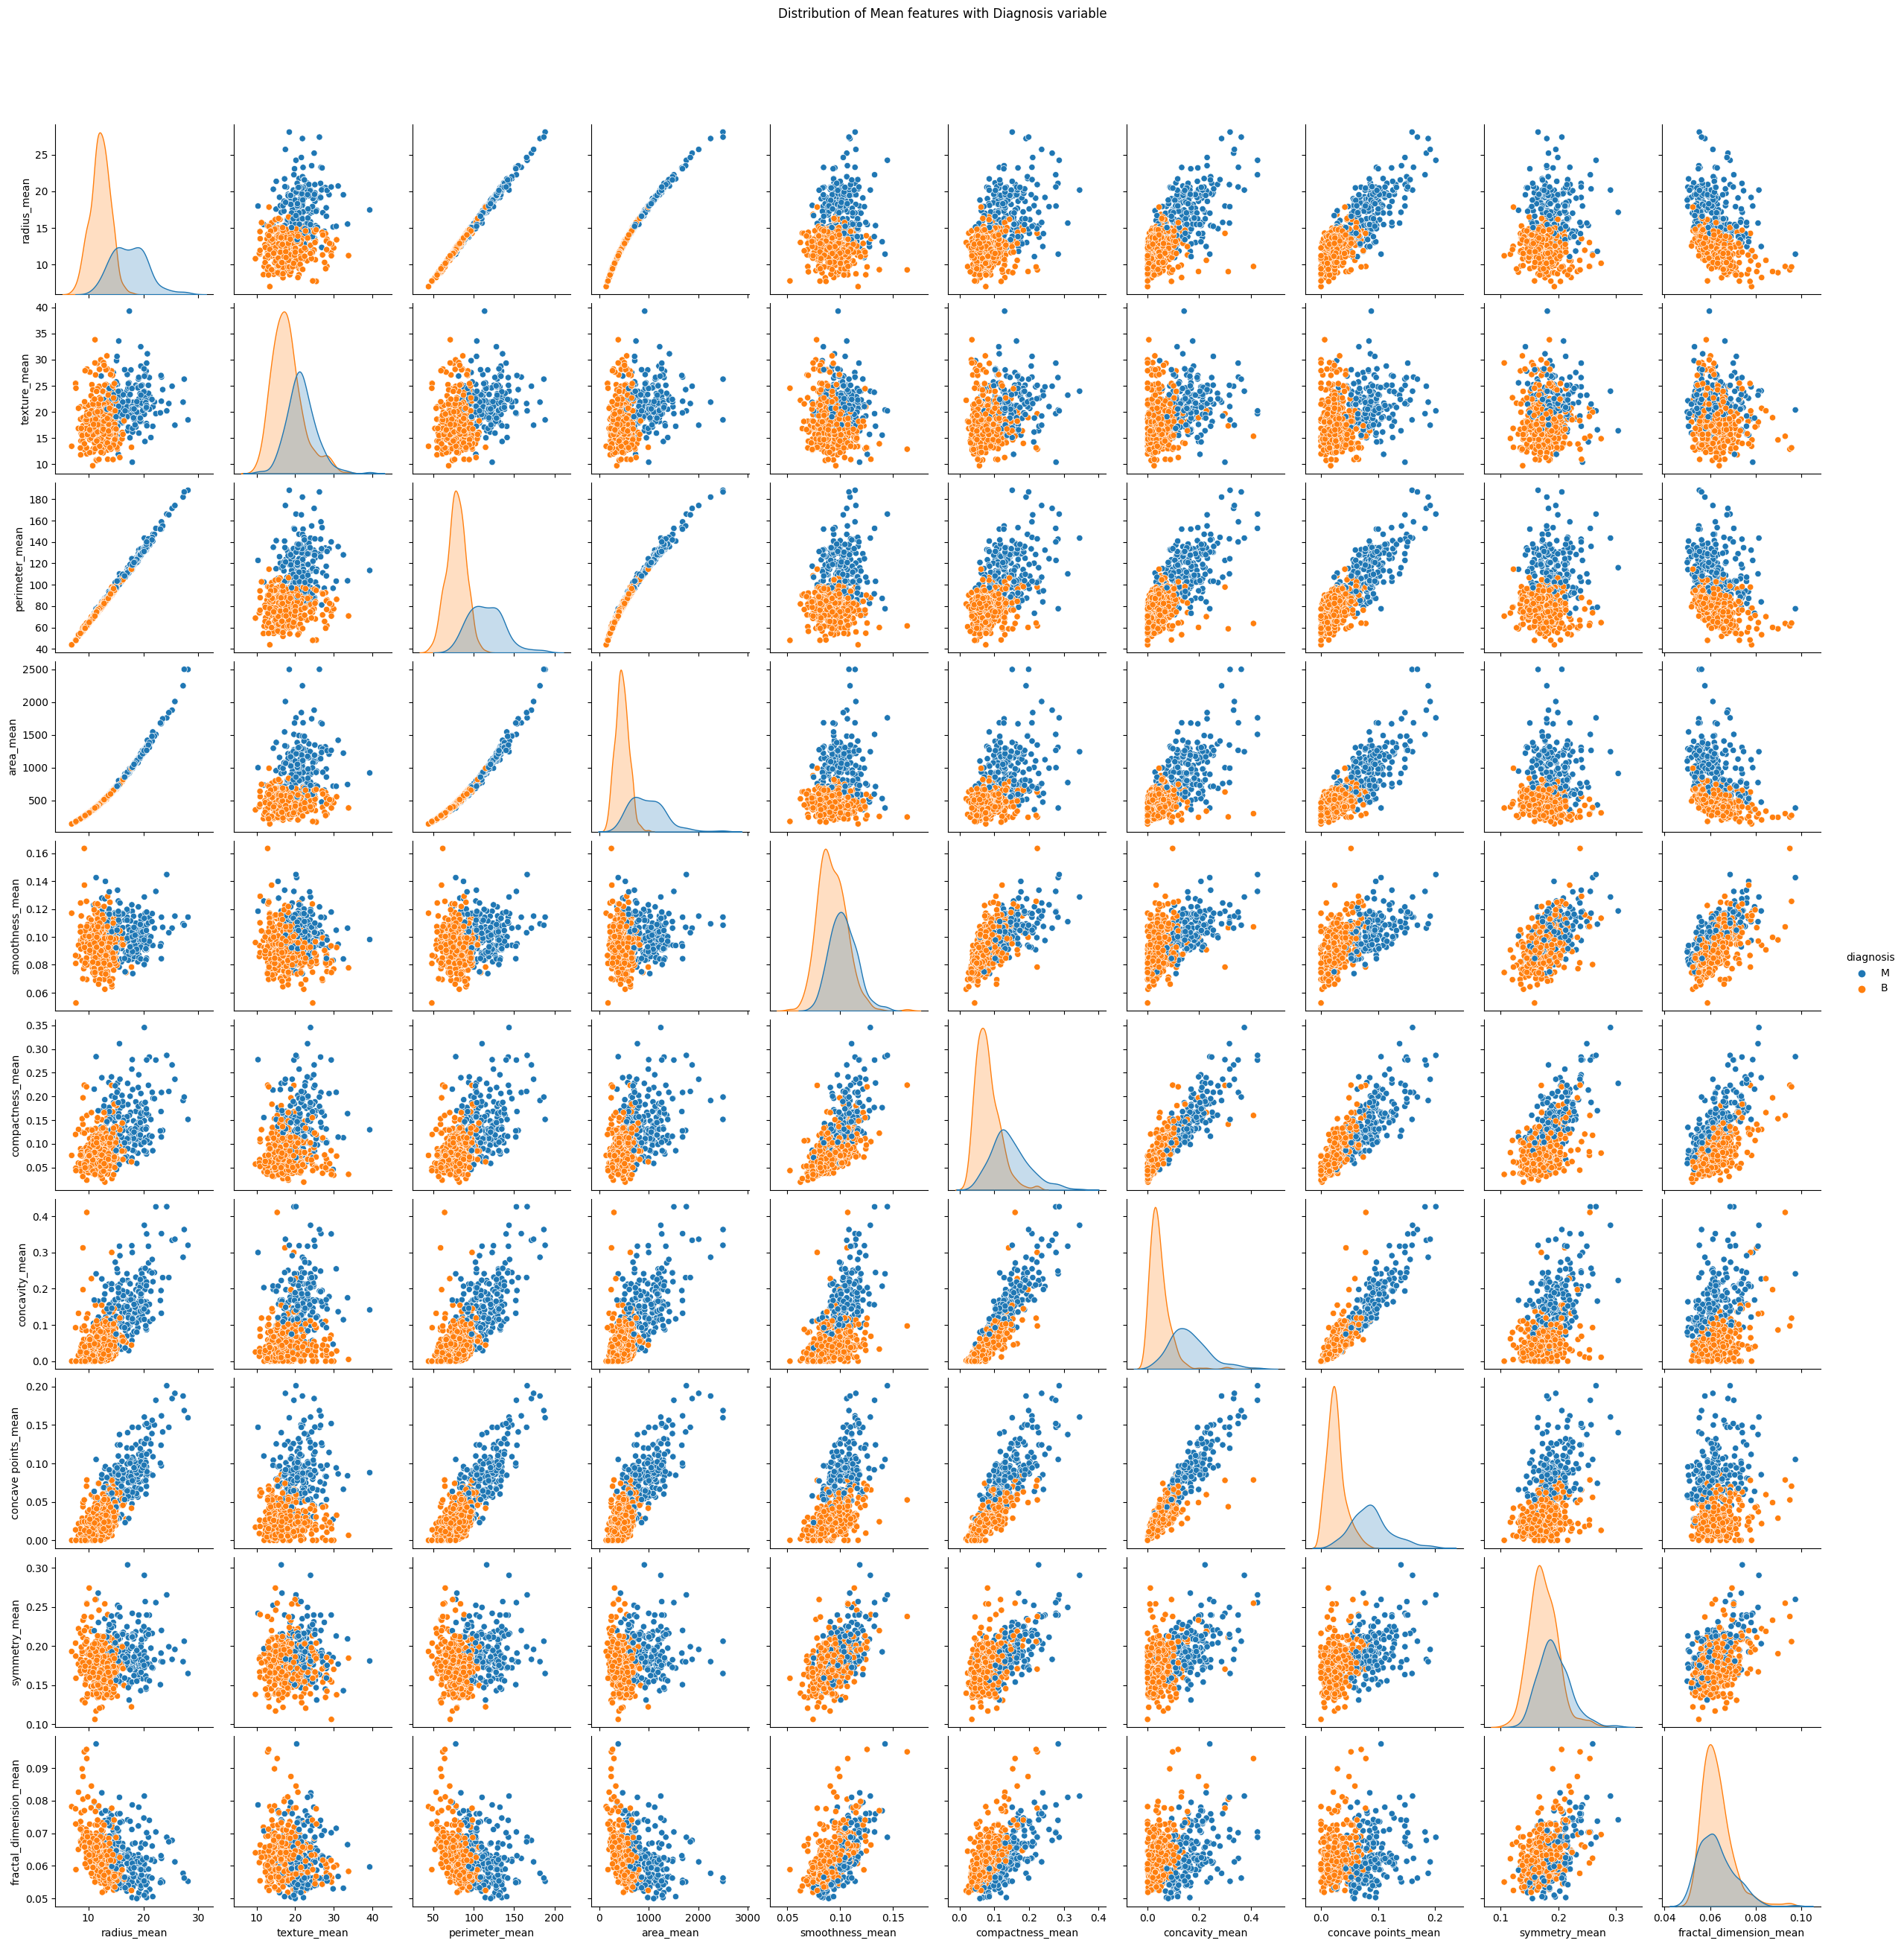

In [82]:
# Create Pairplot to visualize distribution
sns.pairplot(data[[i for i in data.columns if 'mean' in i] + ['diagnosis']], hue = 'diagnosis')
plt.suptitle("Distribution of Mean features with Diagnosis variable", y=1.05)
plt.show()

In [8]:
# Label encode target variable
data['diagnosis'] = data['diagnosis'].map({'M':1, 'B':0})

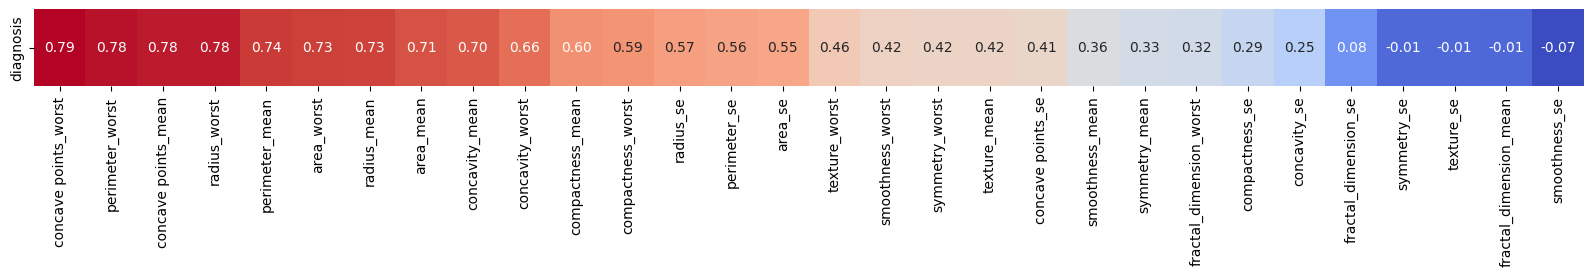

In [9]:
# Since all our columns are numeric we check the correlation
corr_matrix = data.corr()

fig, ax = plt.subplots(figsize=(20, 1))
sns.heatmap(corr_matrix[['diagnosis']][1:].sort_values(by = 'diagnosis', ascending=False).T, cmap='coolwarm', annot=True, fmt='.2f', annot_kws={'size': 10}, cbar=False, xticklabels=True, yticklabels=True)
plt.show()

In [10]:
# Top correlated features
corr_matrix = corr_matrix[['diagnosis']][1:].sort_values(by = 'diagnosis', ascending=False)
sel_cols = list(corr_matrix.nlargest(10, 'diagnosis').index)
print(sel_cols)

['concave points_worst', 'perimeter_worst', 'concave points_mean', 'radius_worst', 'perimeter_mean', 'area_worst', 'radius_mean', 'area_mean', 'concavity_mean', 'concavity_worst']


### Learn the Structure

In [11]:
# Normalize the data
sc = StandardScaler()
ndata = pd.DataFrame(sc.fit_transform(data), columns = data.columns)

In [31]:
sm = from_pandas(ndata[sel_cols + ['diagnosis']], tabu_parent_nodes=['diagnosis'])

### Visualize the learnt structure

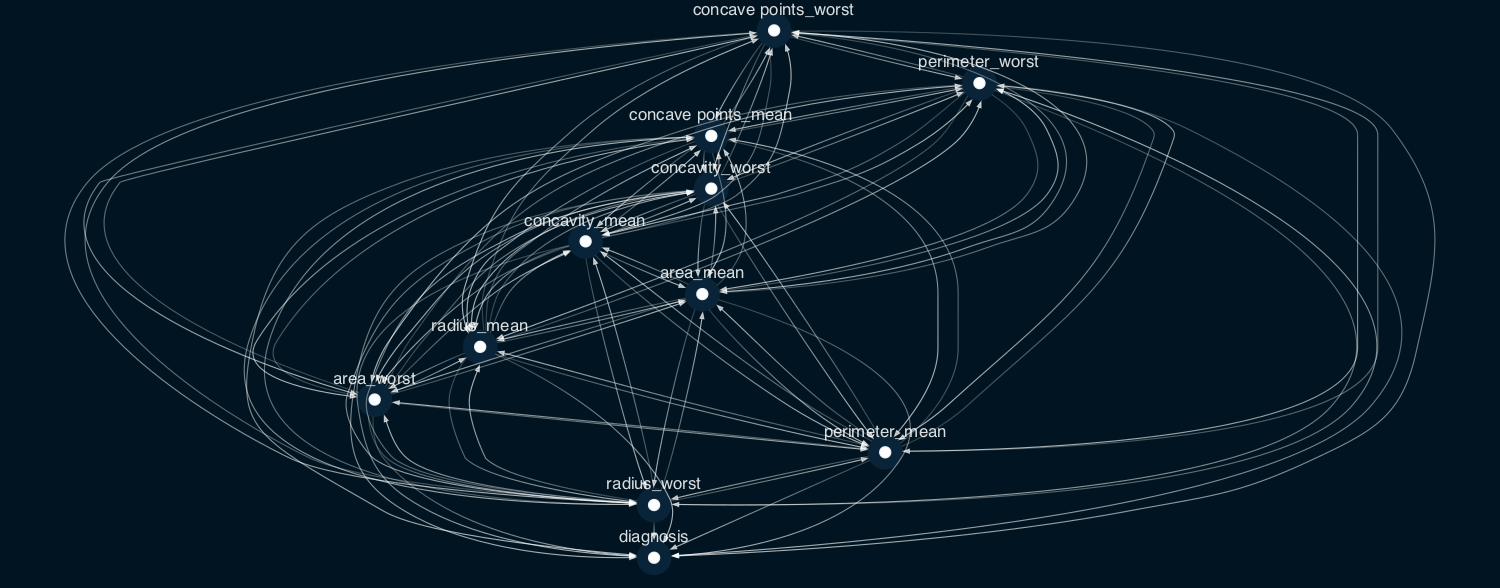

In [32]:
viz = plot_structure(sm, 
                     graph_attributes={"scale": "0.01", "size": 5, "layout": "dot"},
                     all_node_attributes={"style": "filled", "fillcolor": "white", "shape": "circle"},
                     all_edge_attributes={"penwidth": 1, "arrowsize": 0.5})
Image(viz.draw(format='png'))

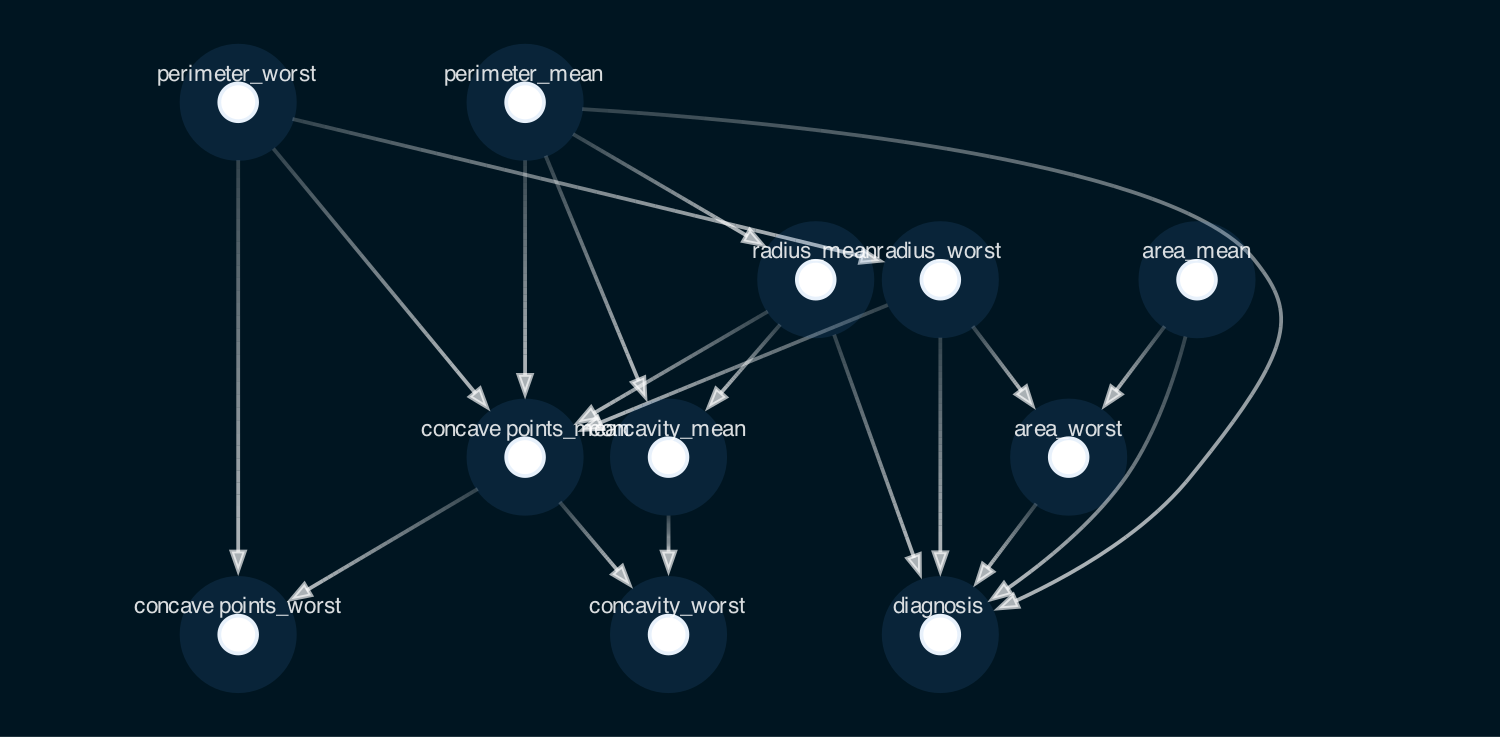

In [52]:
# Removing weaker edges
sm.remove_edges_below_threshold(0.8)

viz = plot_structure(sm, 
                     graph_attributes={"scale": "0.001", "size": 5, "layout": "dot"},
                     all_node_attributes={"style": "filled", "fillcolor": "white", "shape": "circle", "fontsize": 6, "size": 5},
                     all_edge_attributes={"penwidth": 1, "arrowsize": 0.5})
Image(viz.draw(format='png'))

In [17]:
def jaccard_similarity(g, h):
    i = set(g).intersection(h)
    return round(len(i) / (len(g) + len(h) - len(i)), 3)

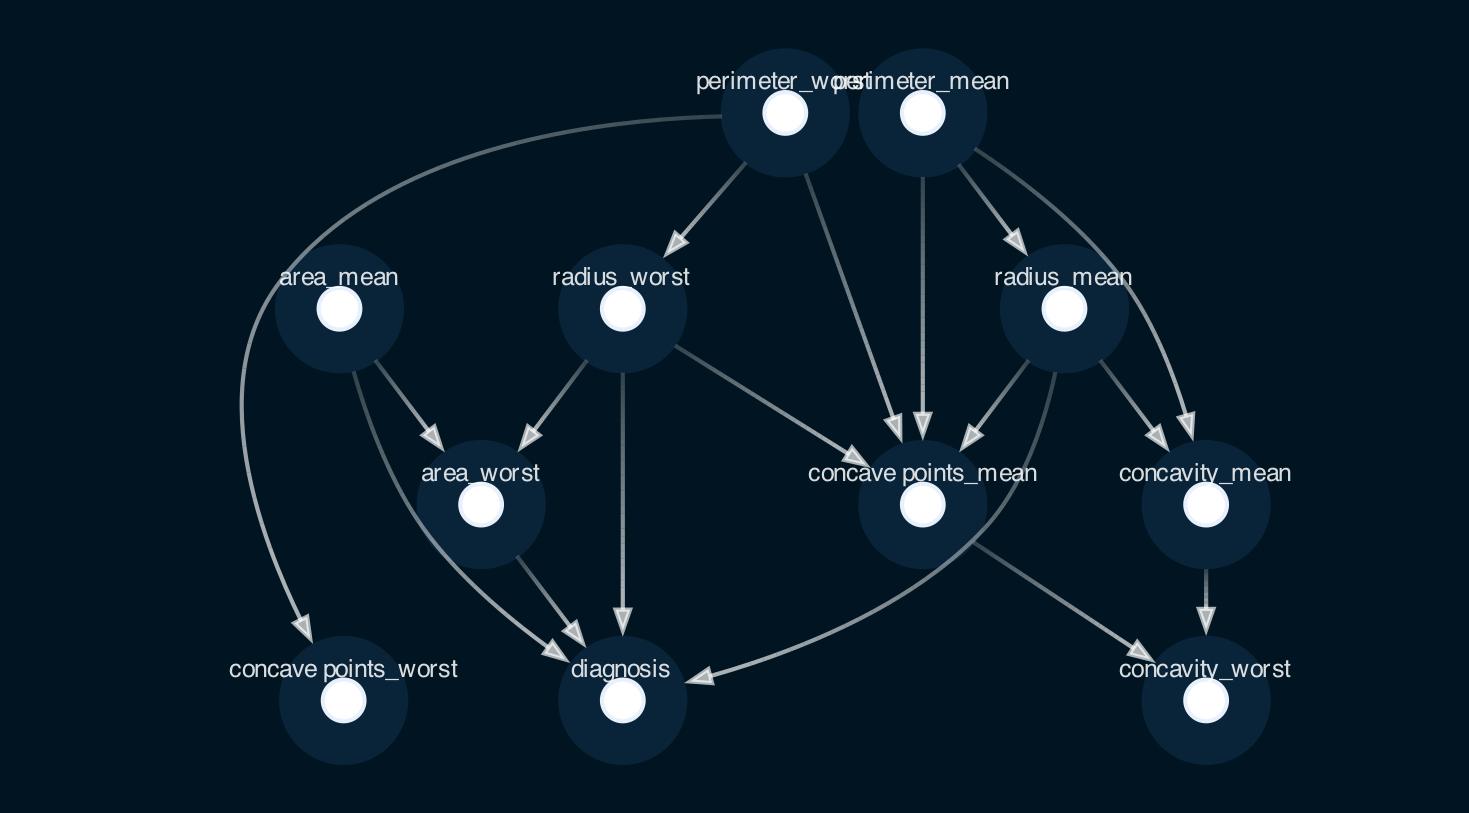

In [53]:
# 60% of Data
x_portion = ndata.sample(frac = 0.6)[sel_cols + ['diagnosis']]
sm2 = from_pandas(x_portion, tabu_parent_nodes=['diagnosis'])
sm2.remove_edges_below_threshold(0.8)
sm2 = sm2.get_largest_subgraph()
viz = plot_structure(sm2, 
                     graph_attributes={"scale": "0.001", "size": 5, "layout": "dot"},
                     all_node_attributes={"style": "filled", "fillcolor": "white", "shape": "circle", "fontsize": 6, "size": 5},
                     all_edge_attributes={"penwidth": 1, "arrowsize": 0.5})
Image(viz.draw(format='png'))

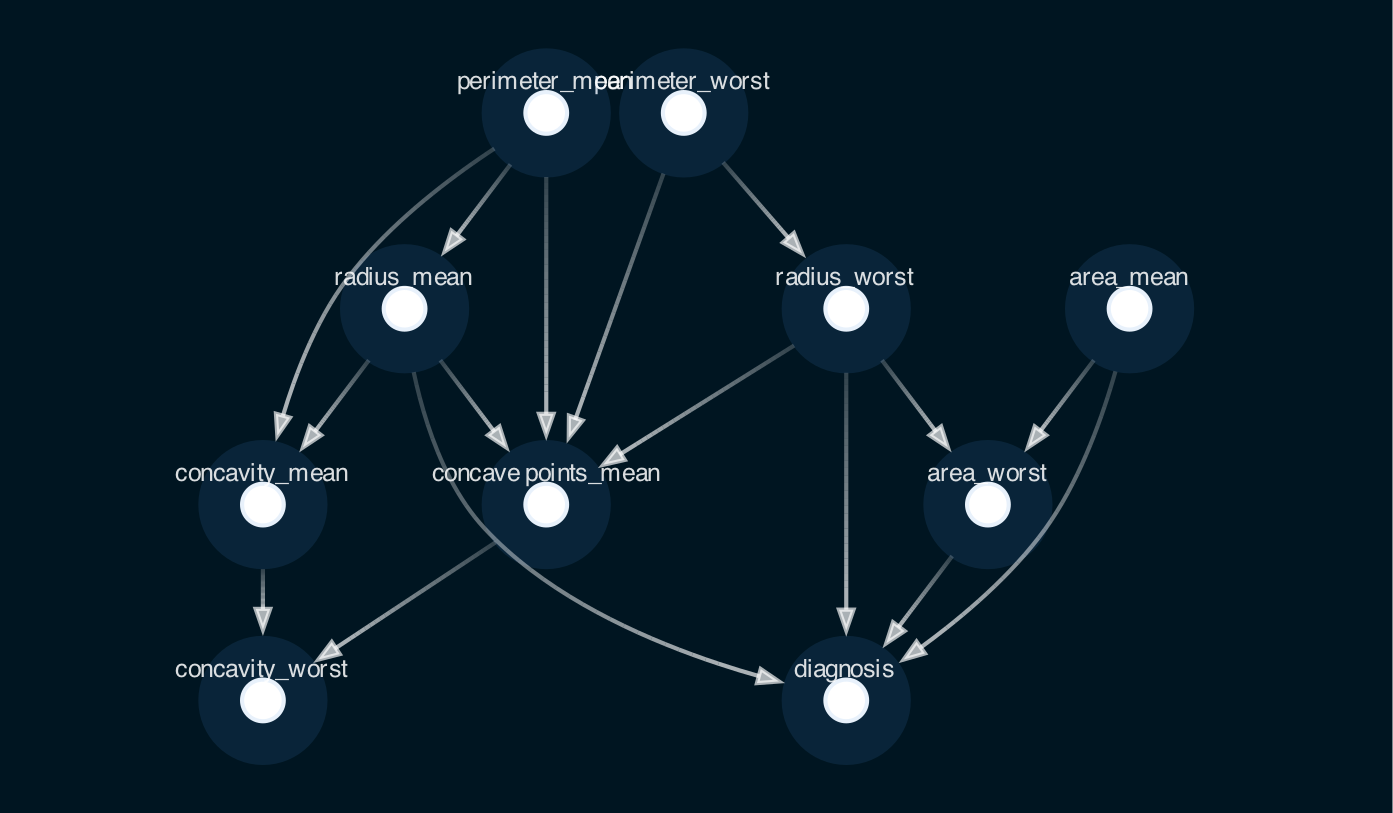

In [54]:
# 70% of Data
x_portion = ndata.sample(frac = 0.7)[sel_cols + ['diagnosis']]
sm3 = from_pandas(x_portion, tabu_parent_nodes=['diagnosis'])
sm3.remove_edges_below_threshold(0.8)
sm3 = sm3.get_largest_subgraph()
viz = plot_structure(sm3, 
                     graph_attributes={"scale": "0.001", "size": 5, "layout": "dot"},
                     all_node_attributes={"style": "filled", "fillcolor": "white", "shape": "circle", "fontsize": 6, "size": 5},
                     all_edge_attributes={"penwidth": 1, "arrowsize": 0.5})
Image(viz.draw(format='png'))

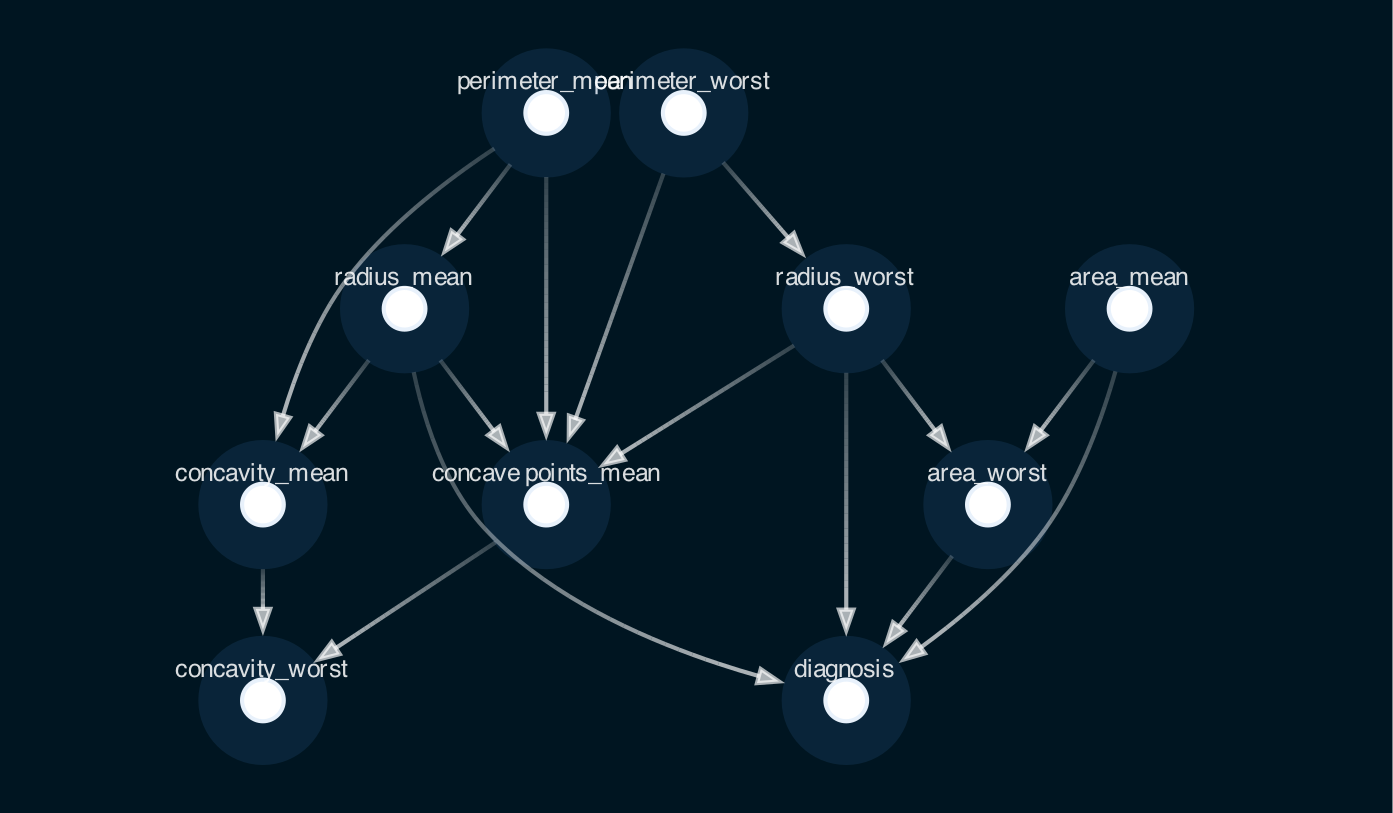

In [55]:
# 80% of Data
x_portion = ndata.sample(frac = 0.8)[sel_cols + ['diagnosis']]
sm4 = from_pandas(x_portion, tabu_parent_nodes=['diagnosis'])
sm4.remove_edges_below_threshold(0.8)
sm4 = sm3.get_largest_subgraph()
viz = plot_structure(sm4, 
                     graph_attributes={"scale": "0.001", "size": 5, "layout": "dot"},
                     all_node_attributes={"style": "filled", "fillcolor": "white", "shape": "circle", "fontsize": 6, "size": 5},
                     all_edge_attributes={"penwidth": 1, "arrowsize": 0.5})
Image(viz.draw(format='png'))

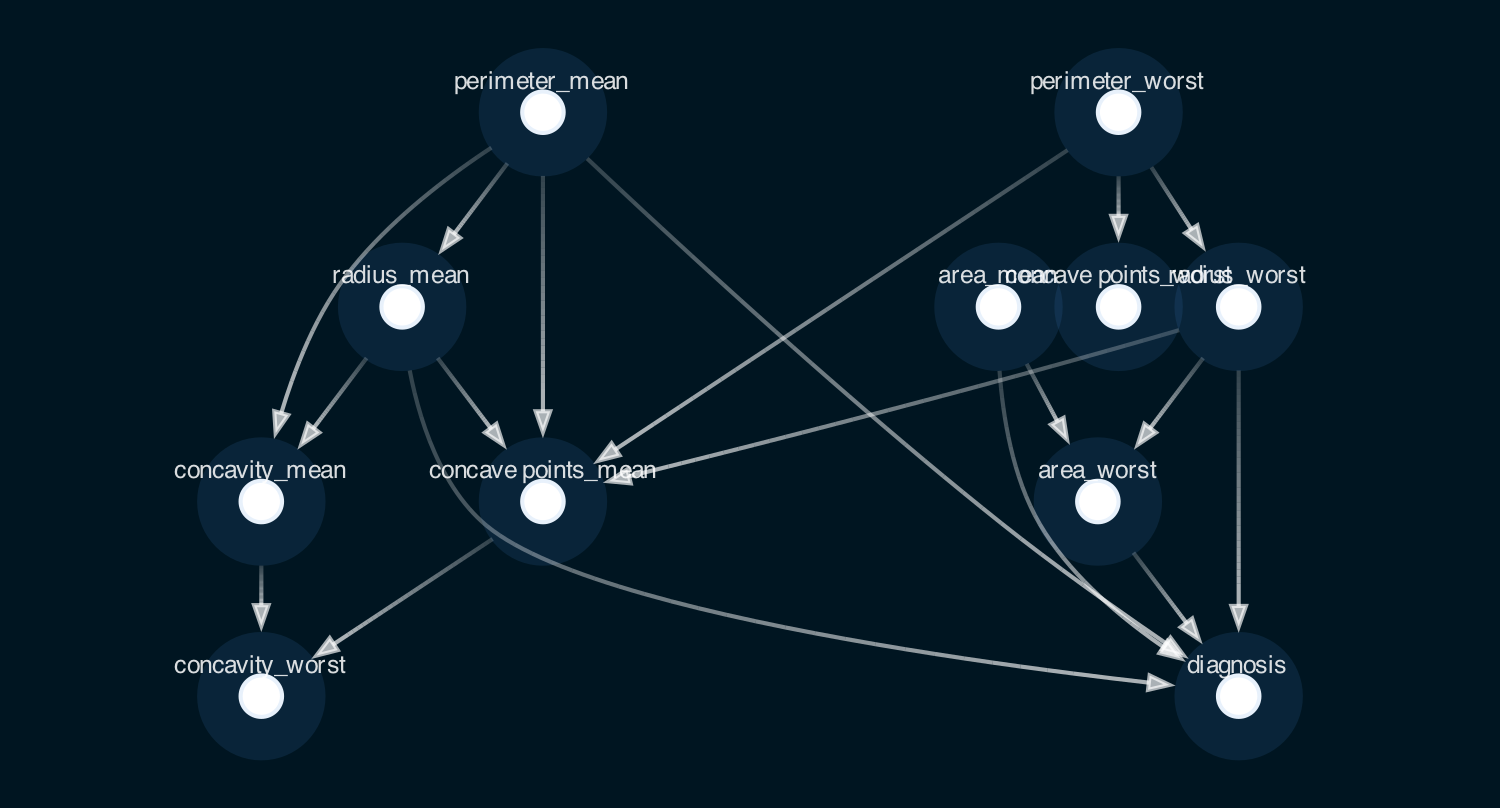

In [56]:
# 90% of Data
x_portion = ndata.sample(frac = 0.9)[sel_cols + ['diagnosis']]
sm5 = from_pandas(x_portion, tabu_parent_nodes=['diagnosis'])
sm5.remove_edges_below_threshold(0.8)
sm5 = sm5.get_largest_subgraph()
viz = plot_structure(sm5, 
                     graph_attributes={"scale": "0.001", "size": 5, "layout": "dot"},
                     all_node_attributes={"style": "filled", "fillcolor": "white", "shape": "circle", "fontsize": 6, "size": 5},
                     all_edge_attributes={"penwidth": 1, "arrowsize": 0.5})
Image(viz.draw(format='png'))

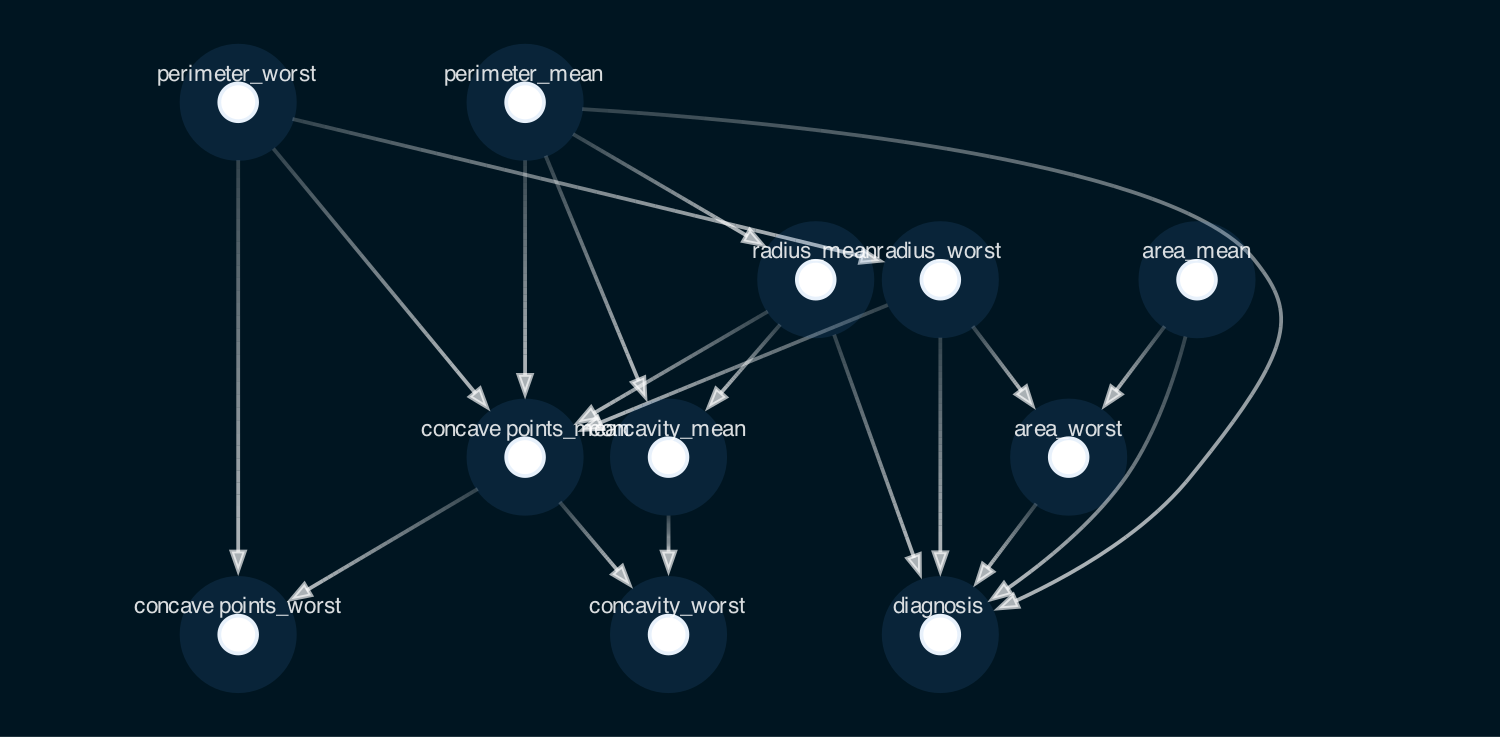

In [57]:
# 100% of Data
x_portion = ndata.sample(frac = 1.0)[sel_cols + ['diagnosis']]
sm6 = from_pandas(x_portion, tabu_parent_nodes=['diagnosis'])
sm6.remove_edges_below_threshold(0.8)
sm6 = sm6.get_largest_subgraph()
viz = plot_structure(sm6, 
                     graph_attributes={"scale": "0.001", "size": 5, "layout": "dot"},
                     all_node_attributes={"style": "filled", "fillcolor": "white", "shape": "circle", "fontsize": 6, "size": 5},
                     all_edge_attributes={"penwidth": 1, "arrowsize": 0.5})
Image(viz.draw(format='png'))

### Check stability of graph

In [58]:
# All Jacard Metrics are greater than 80% thus our graph is stable
jdf = pd.DataFrame([['60-70', jaccard_similarity(sm2.edges, sm3.edges)], 
    ['70-80', jaccard_similarity(sm3.edges, sm4.edges)], 
    ['80-90', jaccard_similarity(sm4.edges, sm5.edges)], 
    ['90-100', jaccard_similarity(sm5.edges, sm6.edges)]], columns=['Data Percentage', 'Jaccard Similarity'])

jdf

Data Percentage  Jaccard Similarity
0           60-70               0.941
1           70-80               1.000
2           80-90               0.889
3          90-100               0.947

### Get Markov Blanket of the Graph

In [59]:
bn = BayesianNetwork(sm)

In [60]:
blanket = sm.get_markov_blanket('diagnosis')
edge_list = list(blanket.edges)

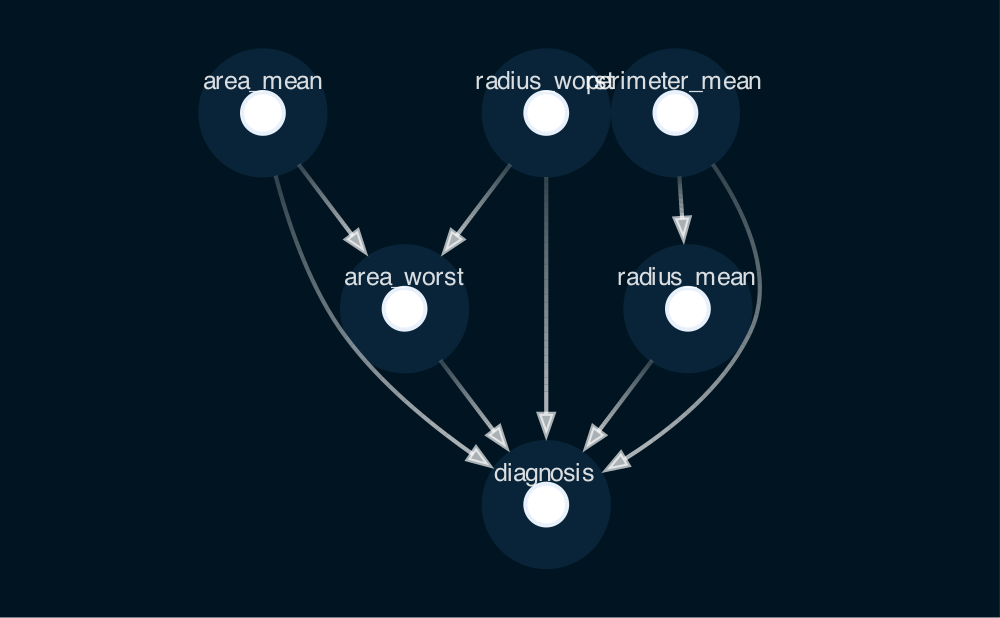

In [61]:
viz = plot_structure(blanket, 
                     graph_attributes={"scale": "0.001", "size": 5, "layout": "dot"},
                     all_node_attributes={"style": "filled", "fillcolor": "white", "shape": "circle", "fontsize": 6, "size": 5},
                     all_edge_attributes={"penwidth": 1, "arrowsize": 0.5})
Image(viz.draw(format='png'))

## Bayesian Network

In [82]:
# Choose best columns
data = data[sel_cols + ['diagnosis']]

# Data to be descritized
discretised_data = data.copy()

# Descetize numeric columns
for col_ in discretised_data.columns[:-1]:
    discretised_data[col_] = Discretiser(method="fixed",
                          numeric_split_points=[discretised_data[col_].quantile(0.25), discretised_data[col_].quantile(0.5), discretised_data[col_].quantile(0.75)]).transform(discretised_data[col_].values)

In [95]:
# Create train test split
train, test = train_test_split(discretised_data, test_size=0.2, random_state=42)

In [100]:
# Fit Bayesian Network model
bn = bn.fit_node_states(train)

In [101]:
# Fit Bayesian Conditional Probability Distribution
bn = bn.fit_cpds(train, method="BayesianEstimator", bayes_prior="K2")

In [102]:
# Inspect Conditional Distributions
bn.cpds["diagnosis"]

area_mean              0                                                    \
area_worst             0                                                     
perimeter_mean         0                                                     
radius_mean            0                        1                   2        
radius_worst           0    1    2    3         0    1    2    3    0    1   
diagnosis                                                                    
0               0.980583  0.5  0.5  0.5  0.666667  0.5  0.5  0.5  0.5  0.5   
1               0.019417  0.5  0.5  0.5  0.333333  0.5  0.5  0.5  0.5  0.5   

area_mean       ...    3                                                    
area_worst      ...    3                                                    
perimeter_mean  ...    3                                                    
radius_mean     ...    1         2                   3                      
radius_worst    ...    2    3    0    1    2    3    0    1    2         3  
diagnosis       ...                                                         
0               ...  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.019231  
1               ...  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.980769  

[2 rows x 1024 columns]

In [120]:
# Get predictions from bayesian network model
tr_preds = bn.predict(train, "diagnosis")
te_preds = bn.predict(test, "diagnosis")

y_train_pred = tr_preds['diagnosis_prediction'].values
y_test_pred = te_preds['diagnosis_prediction'].values

y_train_true = train['diagnosis'].values
y_test_true = test['diagnosis'].values

In [132]:
display(pd.DataFrame(classification_report(bn, test, "diagnosis")))

roc, auc = roc_auc(bn, test, "diagnosis")
print('AUC: ', auc)

diagnosis_0  diagnosis_1  accuracy   macro avg  weighted avg
precision     0.855422     1.000000  0.894737    0.927711      0.909956
recall        1.000000     0.720930  0.894737    0.860465      0.894737
f1-score      0.922078     0.837838  0.894737    0.879958      0.890303
support      71.000000    43.000000  0.894737  114.000000    114.000000

AUC:  0.9737611572791628
